In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%pylab inline
from IPython.core.display import clear_output
import os,shutil
import re
import copy as cp
from scipy import stats
import subprocess
import glob
import pandas as pd
import pmx
from pmx import *
from pmx.parser import *
from pmx.forcefield import *
from pmx.utils import * #create_folder, clean_gromacs_backup_files
from pmx.geometry import *
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from AbsoluteDG import *
from pmx.parser import kickOutComments, readSection
from DoubleBox import *
#from AbsRestraints import *
#import AbsRestraints
#from PositionRestraints import *
#import PositionRestraints
from Restraints import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
#!jt -t chesterish

------------------------------
Perform absolute binding free energy calculations
-----------------------------------

1. setup folder structure: water and complex
2. prepare simulation setup
3. run simulations: em, posre, eq, ti

In [3]:
class TOPdecouple:
    """Class to switch off A or B state of the whole molecule via topology

    Parameters
    ----------
    ...

    Attributes
    ----------
    ....

    """ 

    def __init__(self, **kwargs):
        
        self.ff = ''
        self.itpfile = ''
        self.itpfileA = None # file where A is on and B off
        self.itpfileB = None # file where A is off and B on
        self.ffitpfile = None
        self.bDumOnly = False # for cgenff read non-bondeds from ffnonbonded.itp, 
                              # so ffMOL.itp should contain only dummy entries
    
        for key, val in kwargs.items():
            setattr(self,key,val)

        self.itp = TopolBase(self.itpfile)
        molName = self.itp.name
        molNameA = self.itp.name+'A'
        molNameB = self.itp.name+'B'
        self.newMolNames = [molNameA,molNameB]
        self.itpA = cp.deepcopy(self.itp)
        self.itpA.name = molNameA
        self.itpB = cp.deepcopy(self.itp)       
        self.itpB.name = molNameB

        ##### firstly, generate B-state with qB=0.0 and LJ=0.0    
        self.dummies = []
        if self.itpfileA != None:
            self._modify_charges_lj( self.itpA, bA=True, bB=False )
            self.itpA.write(self.itpfileA,stateBonded='A')
        if self.itpfileB != None:         
            self._modify_charges_lj( self.itpB, bA=False, bB=True )
            self.itpB.write(self.itpfileB, target_qB=[self.qtot],stateBonded='A')
            
        ##### secondly, generate nonbonded-parameters
        # if exists, read ff file
        self.ffdata = {} # atom types for which non-bondeds will be generated
        self.ffdataRest = {} # other atom types for which interactions are not to be explicitly created
        self._read_ffMOL( )
        # generate nonbonded interactions
        self.ffnonbonded = []
        nonbondeds = self._create_nonbondeds( exclude=['DU','HV'] )
        # write ff file
        self._write_nonbondeds( )  
        

    def _modify_charges_lj( self, itp, bA=True, bB=False ):
        self.qtot = 0.0
        for a in itp.atoms:
            q = cp.deepcopy(a.q)
            self.qtot += q
            atype = cp.deepcopy(a.atomtype)
            a.mB = a.m
            self.dummies.append('DUM'+atype)
            
            if bA==False and bB==True:
                a.q = 0.0
                a.qB = q
                if atype.startswith('h') or atype.startswith('H'):
                    a.atomtype = 'HV'+atype
                else:
                    a.atomtype = 'DUM'+atype
                a.atomtypeB = atype
            if bA==True and bB==False:
                # a.q remains unchanged
                a.qB = 0.0
                if atype.startswith('h') or atype.startswith('H'):
                    a.atomtypeB = 'HV'+atype
                else:
                    a.atomtypeB = 'DUM'+atype

    def _read_ffMOL( self ):
        self.ffdata = {}
        if self.ffitpfile!=None:
            # get atom types that are relevant
            atypes = []
        
            for a in self.itp.atoms:
                atypes.append(a.atomtype)

            # read atomtypes: first let's try ffitpfile, e.g. for gaff
            fp = open(self.ffitpfile,'r')
            lines = fp.readlines()
            fp.close()
            # if file is empty need to parse ffnonbonded.itp from the force field, e.g. for cgenff
            if len(lines)==0: 
                gmxlibpath = os.environ['GMXLIB']
                fname = '{0}/{1}/ffnonbonded.itp'.format(gmxlibpath,self.ff)
                fp = open(fname,'r')
                lines = fp.readlines()
                fp.close()
                self.bDumOnly = True
                
            lst = readSection(lines, '[ atomtypes ]', '[')    
            lst = kickOutComments(lst, ';')    
            lst = kickOutComments(lst, '#') # discard ifdefs for waters

            for l in lst:
                l = l.rstrip()
                l = l.lstrip()
                foo = l.split()    

                if len(atypes)>0 and (foo[0] in atypes):
                    self.ffdata[foo[0]] = [float(foo[-2]),float(foo[-1])]
    #                elif len(atypes)==0:
                else:
                    self.ffdataRest[foo[0]] = [float(foo[-2]),float(foo[-1])]
                    
    def _create_nonbondeds( self, exclude=['DU','HV'] ):
        visited = []
        for a1 in self.ffdata.keys():
            for a2 in self.ffdata.keys():
                if (a1[0:2] in exclude) or (a2[0:2] in exclude):
                    continue
            
                key = a1+'_'+a2
                invkey = a2+'_'+a1
                if (key in visited) or (invkey in visited):
                    continue
            
                visited.append(key)
            
                sigma = 0.5*(self.ffdata[a1][0]+self.ffdata[a2][0])
                eps = np.sqrt(self.ffdata[a1][1]*self.ffdata[a2][1])
            
                foo = [a1,a2,sigma,eps]
                if a1.startswith('h') or a1.startswith('H'):
                    a1name = 'HV'+a1
                else:
                    a1name = 'DUM'+a1
                if a2.startswith('h') or a2.startswith('H'):
                    a2name = 'HV'+a2
                else:
                    a2name = 'DUM'+a2
                
                foo = [a1name,a2name,sigma,eps]
                self.ffnonbonded.append(foo)

    def _write_nonbondeds( self ):
        if self.ffitpfile!=None:
            fp = open(self.ffitpfile,'w')
            # output atom types
            fp.write('[ atomtypes ]\n')
            for a in self.ffdata.keys():
                sigma = self.ffdata[a][0]
                eps = self.ffdata[a][1]
                if self.bDumOnly==False:
                    fp.write('%6s  %3.8f  %3.8f  %6s  %3.8f  %3.8f\n' %(a,0.0,0.0,'A',sigma,eps))
                if a.startswith('h') or a.startswith('H'):
                    fp.write('%6s  %3.8f  %3.8f  %6s  %3.8f  %3.8f\n' %('HV'+a,0.0,0.0,'A',0.0,0.0))
                else:
                    fp.write('%6s  %3.8f  %3.8f  %6s  %3.8f  %3.8f\n' %('DUM'+a,0.0,0.0,'A',0.0,0.0))                    
            # now also write atomtypes that have not been implicated in alchemical transition
            if self.bDumOnly==False:
                for a in self.ffdataRest.keys():
                    sigma = self.ffdataRest[a][0]
                    eps = self.ffdataRest[a][1]
                    fp.write('%6s  %3.8f  %3.8f  %6s  %3.8f  %3.8f\n' %(a,0.0,0.0,'A',sigma,eps))             
        
            # output nonbondeds
            fp.write('\n[ nonbond_params ]\n')
            for nb in self.ffnonbonded:
                fp.write('%6s  %6s  %6d  %3.8f  %3.8f\n' %(nb[0],nb[1],1,nb[2],nb[3]))
        
            fp.close()                

In [4]:
from pmx.forcefield import TopolBase

class oneFFfile:
    """Class makes one ff file out of a list of ff files

    Parameters
    ----------
    ...

    Attributes
    ----------
    ....

    """    
    
    def __init__(self, fileList=None, fnameOut=None ):
        
        # atomtypes
        self.atomtypesFinal = []
        self.atomtypesNames = [] # only the names

        # nonbondeds
        self.nonbond_paramsFinal = []
        self.nonbond_paramsKeys = [] # only the keys
        
        for fname in fileList:
            # read atomtypes and nonbondeds
            self.atomtypes = []
            self.nonbond_params = []
            self._read_ffitp(fname)
            
            # retain non-overlapping ones           
            self._check_atomtypes()         
            self._check_nonbond_params()
                
        # write 
        if len(fileList)==0: # create an empty ffMOL.itp
            fp = open(fnameOut,'w')
            fp.close()
        else:
            self.atomtypes = self.atomtypesFinal
            self.nonbond_params = self.nonbond_paramsFinal
            if fnameOut!=None:
                fp = open(fnameOut,'w')
                TopolBase.write_atomtypes( self, fp )
                if len(self.nonbond_params)>0:
                    TopolBase.write_nonbond_params( self, fp )
                fp.close()
            

    def _read_ffitp(self,fname):
        lines = open(fname).readlines()
        lines = kickOutComments(lines, ';')
        TopolBase.read_atomtypes(self,lines)
        TopolBase.read_nonbond_params(self,lines)        
        
        
    def _check_atomtypes( self ):
        # go over the atoms
        for at in self.atomtypes:
            atname = at['name']
            # not yet encountered atom type
            if atname not in self.atomtypesNames:
                self.atomtypesNames.append(atname)
                self.atomtypesFinal.append(at)
            else: # encountered atom type
                atsigma = at['sigma']
                ateps = at['epsilon']
                atEncountered = self._find_atomtype_by_name( atname )
                atEncounteredSigma = atEncountered['sigma']
                atEncounteredEps = atEncountered['epsilon']
                # check if parameters are consistent with the already present atom type
                if(atsigma==atEncounteredSigma) and (ateps==atEncounteredEps):
                    continue # all fine
                else:
                    raise ValueError('Found two atoms of type {0}, but they have different parameters, \
                                     consider renaming atom types'.format(atname))
                                
    def _check_nonbond_params( self ):
        # go over the nonbond params
        for nb in self.nonbond_params:
            atname1 = nb['a1']
            atname2 = nb['a2']
            key = '{0}_{1}'.format(atname1,atname2)
            keyInv = '{0}_{1}'.format(atname2,atname1)
            # not yet encountered atom type
            if (key not in self.nonbond_paramsKeys) and (keyInv not in self.nonbond_paramsKeys):
                self.nonbond_paramsKeys.append(key)
                self.nonbond_paramsKeys.append(keyInv)                
                self.nonbond_paramsFinal.append(nb)
            else: # encountered atom type
                nbsigma = nb['sigma']
                nbeps = nb['epsilon']
                nbEncountered = self._find_nonbonds_by_key( key )
                nbEncounteredSigma = atEncountered['sigma']
                nbEncounteredEps = atEncountered['epsilon']
                # check if parameters are consistent with the already present nonbond params
                if(atsigma==atEncounteredSigma) and (ateps==atEncounteredEps):
                    continue # all fine
                else:
                    raise ValueError('Found nonbond params for atoms {0} {1}, but they have different parameters, \
                                     consider renaming atom types'.format(atname1,atname2))

                    
    def _find_atomtype_by_name( self, atname ):
        for at in self.atomtypesFinal:
            if at['name']==atname:
                return(at)        
            
    def _find_nonbonds_by_key( self, key ):
        for nb in self.nonbond_paramsFinal:
            an1 = nb['a1']
            an2 = nb['a2']
            k = '{0}_{1}'.format(an1,an2)
            kInv = '{0}_{1}'.format(an2,an1)
            if (k==key) or (kInv==key):
                return(nb)                

In [5]:
class FEMolecule:
    """Class contains information about molecule that will be a part of the simulation

    Parameters
    ----------
    ...

    Attributes
    ----------
    ....

    """

    def __init__(self, mol='', molPath='', bDSSB=False, **kwargs):
        
        # molecule: protein, ligand, water, etc
        self.mol = mol
        # path to files for this molecule
        self.molPath = molPath
        
        # topology itp file
        self.topItp = None
        self.topItpPath = None
        ### these are only relevant for DDSB
        self.topItpA = None
        self.topItpPathA = None
        self.topItpB = None
        self.topItpPathB = None  
        # topology ffitp file
        self.topFFItp = None
        self.topFFItpPath = None            
        # posre itp file
        self.posreItp = None
        self.posreItpPath = None
        # structure file
        self.structPdb = None
        self.structPdbPath = None
        self.natoms = 0 # number of atoms from the structure
        # molecule name in itp
        self.molItpName = ''
        if ('water' in mol) or ('sol' in mol):
            self.molItpName = 'SOL'  
        # number of molecules
        self.molNumber = 0     
        
        self._identify_files( bDSSB=bDSSB )
        
        # number of molecules
        if self.molNumber==0:
            if ('water' in mol) or ('sol' in mol): # get the number of waters from pdb
                self.molNumber = self._count_waters_in_pdb( self.structPdbPath )
            else:
                self.molNumber = 1
        
    def _count_waters_in_pdb( self, pdbfile ):
        m = Model(pdbfile, bPDBTER=False)
        watNum = len(m.residues)
        return(watNum)
        
    def _identify_files( self, bDSSB=False ):
        
        foldersFiles = os.listdir( self.molPath )
        
        for f in foldersFiles:
            fpath = os.path.abspath('{0}/{1}'.format(self.molPath,f))
            
            if os.path.isfile(fpath):
                if f.endswith('itp'):
                    if f.startswith('ff'):
                        self.topFFItp = f
                        self.topFFItpPath = fpath
                    elif 'posre' in f:
                        self.posreItp = f
                        self.posreItpPath = fpath
                    else:
                        if (self.mol in f) or (self.topItp==None):
                            self.topItp = f
                            self.topItpPath = fpath
                            # molecule name from itp
                            top = TopolBase(fpath)
                            self.molItpName = top.name
                if f.endswith('pdb'):
                    # structure: prefer .pdb named the same as the folder
                    if (self.mol+'.pdb'==f) or (self.structPdb==None):
                        self.structPdb = f
                        self.structPdbPath = fpath
                        self.natoms = len(Model(fpath).atoms)
                if f.endswith('top'):
                    # count molecule number
                    top = TopolBase(fpath)
                    self.molNumber = top.molecules[0][1]

In [8]:
class AbsoluteDG:
    """Class contains parameters for setting up free energy calculations

    Parameters
    ----------
    ...

    Attributes
    ----------
    ....

    """

    def __init__(self, **kwargs):
        
        # set gmxlib path if it is not set
        if os.environ['GMXLIB']=='':
            gmx.set_gmxlib()
        
        # the results are summarized in a pandas framework
        self.resultsAll = pd.DataFrame()
        self.resultsSummary = pd.DataFrame()
        
        # paths
        self.workPath = './'
        self.mdpPath = '{0}/mdp'.format(self.workPath)
        self.structTopPath = None
        self.bTopologiesCollected=False # automatically collect topologies when initializing the object
        self.gmxexec = None # set gmx executable (optional)
        
        # information about inputs
        self.ligands = {} # a dictionary containing all classes of molecules for that ligand case: ligands[ligname]=[protein,ligand,water,...]
        self.ligandPaths = {} # ligandPaths[ligname]=path
        self.ligList = [] # list of ligand names
        self.apoCase = None # name of the apo folder if exists
        self.ffitp = {} # full path for ff.itp file for every ligand: ffitp[lig]['apo'] = path/ff.itp
        self.iiRestrFile = {} # intermolecular interactions file which will be generated during setup; has two cases 'apo' and 'holo'
        
        # parameters for the general setup
        self.replicas = 3        
        self.simTypes = ['em','eq','transitions']
        self.states = ['stateA','stateB']
        self.bDSSB = False
        self.thermCycleBranches = ['water','protein']  
        # if bDSSB, define a parameter for the distance between the molecules and bool for longest axis 
        self.rdssb = 2.5
        self.bdssbLongestAxis = False
        self.bGenTiTpr = True # should the TI tpr be generated locally
                
        # simulation setup
        self.ff = 'amber99sb-star-ildn-mut.ff'
        self.boxshape = 'dodecahedron'
        self.boxd = 1.5
        self.water = 'tip3p'
        self.conc = 0.15
        self.pname = 'NaJ'
        self.nname = 'ClJ'
        self.equilTime = 1080.0 # ps to discard for equilibration
        self.frameNum = 100 # number of transitions
        self.temperature = 298.15
        
        # job submission params
        self.JOBqueue = 'SGE' # could be SLURM
        self.JOBsimtime = 24 # hours
        self.JOBsimcpu = 8 # CPU default
        self.JOBbGPU = True
        self.JOBmodules = []
        self.JOBsource = []
        self.JOBexport = []
        self.JOBgmx = 'gmx mdrun'
        self.JOBarray = True # should the transitions be submitted as array jobs
        self.JOBpartition = 'p24,p20,p16,p10,p08'

        for key, val in kwargs.items():
            setattr(self,key,val)
            
        if self.bDSSB==True:
            self.thermCycleBranches = ['dssb']
            
        if 'charmm' in self.ff:
            self.pname = 'NA'
            self.nname = 'CL'      
            
            
    def prepareFreeEnergyDir( self ):
        
        # identify ligands in the structTopPath
        self._identify_ligands( self.structTopPath )
               
        # read mdpPath
        self.mdpPath = self._read_path( self.mdpPath )
        
        # workpath
        self.workPath = self._read_path( self.workPath )
        create_folder( self.workPath )
        
        # create folder structure 
        self._create_folder_structure( )

        # collect topologies in the respective folder
        if self.bTopologiesCollected==False:
            self._collect_topologies( )
            self.bTopologiesCollected=True
        
        # print summary
        self.print_summary( )
                        
        # print folder structure
        self.print_folder_structure( )    
        
        print('\nDONE')     
        

    def _identify_ligands( self, path ):
        path = self._read_path(path)
        folders = os.listdir(path)
        
        # go over folders and check if they could be for ligands, alternatively go over ligand list
        ligFolderList = folders
        if len(self.ligList)>0:
            ligFolderList = self.ligList
                      
        for f in ligFolderList+[self.apoCase]:
            ligff = os.path.abspath('{0}/{1}'.format(path,f))
            if os.path.isdir(ligff):
                
                # check if 'protein' and 'ligand' folders are in there
                ligandFolder = os.path.abspath('{0}/ligand'.format(ligff))
                proteinFolder = os.path.abspath('{0}/protein'.format(ligff))
                if os.path.isdir(ligandFolder) and os.path.isdir(proteinFolder): # for apo state
                    if (f not in self.ligList) and (f!=self.apoCase):
                        self.ligList.append(f)
                elif os.path.isdir(proteinFolder): # for apo state
                    self.apoCase = f
                else:
                    continue
                    
                # check all the folders
                ligandFolders = os.listdir( ligff )
                self.ligands[f] = {}
                for lf in ligandFolders:
                    molFolder = os.path.abspath('{0}/{1}'.format(ligff,lf))
                    if os.path.isdir(molFolder):
                        if lf=='ligand':                            
                            self.ligands[f][lf] = FEMolecule( mol=lf, molPath=molFolder, bDSSB=self.bDSSB )
                        else:
                            self.ligands[f][lf] = FEMolecule( mol=lf, molPath=molFolder, bDSSB=False )
                       
    
    def _create_folder_structure( self ):

        for lig in self.ligList:
            
            ligPath = '{0}/{1}'.format(self.workPath,lig)
            create_folder(ligPath)
            
            # folder structures and topologies
            structTopFolder = '{0}/strTopFolder_apo'.format(ligPath)
            create_folder(structTopFolder)
            structTopFolder = '{0}/strTopFolder_holo'.format(ligPath)
            create_folder(structTopFolder)
            
            # water/protein or dssb
            for wp in self.thermCycleBranches:
                wppath = '{0}/{1}'.format(ligPath,wp)
                create_folder(wppath)
                
                # stateA/stateB
                for state in self.states:
                    statepath = '{0}/{1}'.format(wppath,state)
                    create_folder(statepath)
                    
                    # run1/run2/run3
                    for r in range(1,self.replicas+1):
                        runpath = '{0}/run{1}'.format(statepath,r)
                        create_folder(runpath)
                        
                        # em/eq_posre/eq/transitions
                        for sim in self.simTypes:
                            simpath = '{0}/{1}'.format(runpath,sim)
                            create_folder(simpath)                           
    
            
    def assemble_systems( self, ligs=None ):
        print('----------------------')
        print('Assembling the systems')
        print('----------------------')
        if self.bDSSB==True:
            print('Order DSSB: ligand-protein-ligand-other-water')
        else:
            print('Order: ligand-protein-other-water')

        if ligs==None:
            ligs = self.ligList
        for lig in ligs:
            
            print('--- Assembling structures: {0} ---'.format(lig))
            ####### protein or DSSB ###########
            # holo structures
            molListHolo = self._assemble_system_structures( lig=lig, case='holo' )
            # apo structures
            molListApo = self._assemble_system_structures( lig=lig, case='apo' ) 
            ####### water ###########
            # to be implemented
            # very simple: self._assemble_ligand_structure( lig=lig )

            print('--- Assembling topologies: {0} ---'.format(lig))
            ####### protein or DSSB ###########            
            # holo topologies
            self._assemble_system_topologies( lig=lig, case='holo', molList=molListHolo )
            # apo topologies
            self._assemble_system_topologies( lig=lig, case='apo', molList=molListApo )
            ####### water ###########
            # to be implemented
            # very simple: self._assemble_ligand_topology( lig=lig )      
            
            
    def _assemble_system_structures( self, lig='', case='holo' ):
        
        # collect here molecules to be added into topology
        molList = [] 
        
        ####### PATHS ######                        
        strPath = self._get_specific_path( lig=lig, case=case, bStrTop=True )
        # it is also convenient to define holo path, as sometimes apo state is not available explicitly
        strPathHolo = self._get_specific_path( lig=lig, case='holo', bStrTop=True )
        if self.bDSSB==True:
            outPath = self._get_specific_path( lig=lig, state=case, wp='dssb' )
        else:
            outPath = self._get_specific_path( lig=lig, state=case, wp='protein' )            
        
        ####### TRANSLATION ROTATION ######
        # if there is a separate apo case, need to position the ligand in there
        # for that determine translation vector and rotation matrix
        if case=='apo' and self.apoCase!=None:
            protPdbHolo = '{0}/{1}'.format(strPathHolo,self.ligands[lig]['protein'].structPdb)
            protPdbApo = '{0}/{1}'.format(strPath,self.ligands[lig]['protein'].structPdb)
            translHolo,translApo,R = self._get_transl_rot( protPdbHolo,protPdbApo ) # fit Apo on Holo
        
        ######## LIGAND #####
        # start the init.pdb with the ligand structure
        # ligand always comes from the holo folder
        ligStrFile = '{0}/{1}'.format(strPathHolo,self.ligands[lig]['ligand'].structPdb)
        systemStrFile = '{0}/system.pdb'.format(outPath)
        cmd = 'cp {0} {1}'.format(ligStrFile,systemStrFile)
        os.system(cmd)
        molList.append(self.ligands[lig]['ligand'])
             
        ######## LIGAND AND PROTEIN ######
        # combine ligand and protein
        protStrFile = '{0}/{1}'.format(strPath,self.ligands[lig]['protein'].structPdb)
        if case=='apo' and self.apoCase!=None:
            protStrFileFit = '{0}/protein_fit.pdb'.format(strPath)
            self._translate_rotate( protStrFile, protStrFileFit, translHolo, translApo, R )
            self._make_clean_pdb([protStrFileFit],systemStrFile,bAppend=True)
            self.ligands[self.apoCase]['protein'].structPdb = 'protein_fit.pdb'
            self.ligands[self.apoCase]['protein'].structPdbPath = protStrFileFit
            molList.append( self.ligands[self.apoCase]['protein'] )
        else:
            self._make_clean_pdb([protStrFile],systemStrFile,bAppend=True)
            molList.append(self.ligands[lig]['protein'])            
                
        ######## OTHER MOLECULES ######            
        # add other molecules
        bWater=False
        for mol in list(self.ligands[lig].keys()):
            if (mol=='protein') or (mol=='ligand'): # already considered
                continue
            else:
                molStrFile = '{0}/{1}'.format(strPath,self.ligands[lig][mol].structPdb)             
                if case=='apo' and self.apoCase!=None:
                    molStrFileFit = '{0}/{1}_fit.pdb'.format(strPath,self._name_without_extension(self.ligands[lig][mol].structPdb))
                    self._translate_rotate( molStrFile, molStrFileFit, translHolo, translApo, R )
                    self._make_clean_pdb([systemStrFile,molStrFileFit],systemStrFile)                    
                else:
                    self._make_clean_pdb([systemStrFile,molStrFile],systemStrFile)
                if mol!='water': # append water last
                    if case=='apo' and self.apoCase!=None:
                        molList.append(self.ligands[self.apoCase][mol])                        
                    else:
                        molList.append(self.ligands[lig][mol])
                else:
                    bWater=True
        if bWater==True: # now append water
            if case=='apo' and self.apoCase!=None:
                molList.append(self.ligands[self.apoCase]['water'])                
            else:
                molList.append(self.ligands[lig]['water'])
     
        ######## PLACE SECOND LIGAND FOR DSSB ######                    
        # if bDSSB, place the second ligand
        if self.bDSSB==True:
            db = DoubleBox(r=self.rdssb,
                               d=self.boxd,
                               pdb1=systemStrFile,
                               pdb2=ligStrFile,
                               outfile=systemStrFile,
                               bLongestAxis=self.bdssbLongestAxis)            
        molList.append(self.ligands[lig]['ligand'])       
            
        ######### PLACE WATER IN THE END ######## 
        # water comes last
        self._place_water_in_the_end( systemStrFile )  
        
        return(molList)
    
        
    def _assemble_system_topologies( self, lig='', case='holo', molList=[] ):
        
        strPath = self._get_specific_path( lig=lig, case=case, bStrTop=True )
        
        if self.bDSSB==True:
            outPath = self._get_specific_path( lig=lig, state=case, wp='dssb' )
            outPathHolo = self._get_specific_path( lig=lig, state='holo', wp='dssb' )
        else:
            outPath = self._get_specific_path( lig=lig, state=case, wp='protein' )                    
            outPathHolo = self._get_specific_path( lig=lig, state='holo', wp='protein' )                    
            

        ##### HYBRID TOPOLOGIES IF DSSB
        # create hybrid topologies
        ffitpfile = self.ffitp[lig][case]
        if self.bDSSB==True:
            itpfile = '{0}/{1}'.format(strPath,self.ligands[lig]['ligand'].topItp)
            itpfileA = '{0}A.itp'.format(self._name_without_extension(itpfile))
            itpfileB = '{0}B.itp'.format(self._name_without_extension(itpfile))
            ffitpfile = self.ffitp[lig][case]
            topDecoupleObj = TOPdecouple( ff=self.ff, itpfile=itpfile, itpfileA=itpfileA, itpfileB=itpfileB, ffitpfile=ffitpfile )
            newMolNames = topDecoupleObj.newMolNames # for DSSB the molecules are renamed in the ITP
            newMolItps = [itpfileA,itpfileB]    
        
        
        ####### CREATE TOP ######
        topFname = '{0}/topol.top'.format(outPath)
        itps = [ os.path.relpath( self.ffitp[lig][case], start=outPath ) ]
        mols = []
        systemName = 'system {0}'.format(case)
        water = None # water is special, i.e. append to the end
        
        for mol in molList:
            # water comes last, here only save it
            if mol.molItpName=='SOL' or mol.molItpName=='HOH' or mol.molItpName=='WAT' or \
               mol.molItpName=='Water' or mol.molItpName=='TIP3':
                water = mol
            else:
                molName = mol.molItpName
                # in case of DSSB need to replace molecule names, as there are now two different molecules
                if molName==self.ligands[lig]['ligand'].molItpName and self.bDSSB==True:
                    molName = newMolNames.pop(0)
                    molItp = os.path.relpath( newMolItps.pop(0),start=outPath )
                    itps.append( molItp )
                else:
                    if mol.topItp!=None:
                        molItp = os.path.relpath( '{0}/{1}'.format(strPath,mol.topItp),start=outPath )                   
                        itps.append( molItp )                    
                mols.append([molName,mol.molNumber])   

        # water comes last
        if water!=None:
            mols.append([water.molItpName,water.molNumber])
        
        self._create_top(fname=topFname,itp=itps,mols=mols,systemName=systemName)         
        
        
        ####### INTERMOLECULAR RESTRAINTS ######
        # for holo state generate the restraints
        self.iiRestrFile[case] = None
        if case=='holo':
            strFile = '{0}/system.pdb'.format(outPath)
            ligItpFile = self.ligands[lig]['ligand'].topItpPath          
            protItpFile = self.ligands[lig]['protein'].topItpPath
            indLig = arange(0,self.ligands[lig]['ligand'].natoms)
            indProt = arange(self.ligands[lig]['ligand'].natoms,self.ligands[lig]['protein'].natoms)
            self.iiRestrFile[case] = '{0}/ii.itp'.format(strPath)
            restrDgFile = '{0}/restr_dG.dat'.format(strPath)
            restrAtomsFile = '{0}/restr_atoms.pdb'.format(strPath)
            
            AbsRestraints( strFile=strFile, topLigFile=ligItpFile, topProtFile=protItpFile,
                            indLig=indLig, indProt=indProt, outiiFile=self.iiRestrFile[case], dgFile=restrDgFile,
                            pdbRestrAtoms=restrAtomsFile)                    
        else: # for apo state, copy or transfer the restraints
            strPathHolo = self._get_specific_path( lig=lig, case='holo', bStrTop=True )
            iiRestrFileHolo = '{0}/ii.itp'.format(strPathHolo)
            self.iiRestrFile[case] = '{0}/ii.itp'.format(strPath)
        
            # need to transfer the restraints
            if self.apoCase!=None: 
                strFileHolo = '{0}/system.pdb'.format(outPathHolo)        
                strFileApo = '{0}/system.pdb'.format(outPath)         
                restrAtomsFile = '{0}/restr_atoms.pdb'.format(strPath)
                transfer_ii( strFileHolo, strFileApo, iiRestrFileHolo, self.iiRestrFile[case], pdbRestrAtoms=restrAtomsFile )
            else: # can simply copy the restraints
                cmd = 'cp {0} {1}'.format(iiRestrFileHolo,self.iiRestrFile[case])
                os.system(cmd)        
            
        # save the ii file to later append it to the final top file
        self.iiRestrFile[case] = os.path.relpath( self.iiRestrFile[case], start=outPath )        
        
        ####### IF DSSB, RESTRAIN TWO COMs: PROTEIN AND LIGAND ######
        if self.bDSSB==True:        
            # restrain ligand (topology B)
            ligandStrFile = self.ligands[lig]['ligand'].structPdbPath
            ligandItpFile = itpfileB
            outLigandItpFile = itpfileB                    
            PositionRestraints( itpname=ligandItpFile, outname=outLigandItpFile, 
                                pdbfile=ligandStrFile, bPosreIfdef=False, stateBonded='A',
                                bIgnoreIfdefs=True)
            
            # restrain protein
            protStrFile = self.ligands[lig]['protein'].structPdbPath
            protItpFile = self.ligands[lig]['protein'].topItpPath
            if case=='apo':
                protStrFile = self.ligands[self.apoCase]['protein'].structPdbPath
                protItpFile = self.ligands[self.apoCase]['protein'].topItpPath                
            outProtItpFile = '{0}/{1}'.format(strPath,self.ligands[lig]['protein'].topItp) 
            PositionRestraints( itpname=protItpFile, outname=outProtItpFile, 
                                pdbfile=protStrFile, name='CA', bPosreIfdef=False)

    def _add_to_topfile( self, topFname,iiRestrFile ):
        fp = open(topFname,'a')
        fp.write( '\n#include "{0}"\n'.format(iiRestrFile) )
        fp.close()
        
    def _create_top( self, fname='topol.top',
                   itp=['merged.itp'], mols=[['MOL',1]],
                   systemName='simulation system',
                   destination='',toppaths=[] ):

        fp = open(fname,'w')
        # ff itp
        fp.write('#include "%s/forcefield.itp"\n' % self.ff)
        # additional itp
        for i in itp:
            fp.write('#include "%s"\n' % i)
        # water itp
        fp.write('#include "%s/%s.itp"\n' % (self.ff,self.water))
        # ions
        fp.write('#include "%s/ions.itp"\n\n' % self.ff)
        # system
        fp.write('[ system ]\n')
        fp.write('{0}\n\n'.format(systemName))
        # molecules
        fp.write('[ molecules ]\n')
        for mol in mols:
            fp.write('%s %s\n' %(mol[0],mol[1]))
        fp.close()                    
            
                       
                    
    def _collect_topologies( self ):
        
        # for every ligand
        for lig in self.ligList:
            fflist = [] # sufficient to collect ff for holo
            self.ffitp[lig] = {}
            
            # for every molecule in the ligand            
            for mol in self.ligands[lig].keys():

                # collect holo
                self._collect_topologies_apo_holo( case='holo', lig=lig, mol=mol, fflist=fflist )
                
                # collect apo
                self._collect_topologies_apo_holo( case='apo', lig=lig, mol=mol )    
                                
            # one ff file
            # holo
            ffout = '{0}/{1}/strTopFolder_holo/ffMOL.itp'.format(self.workPath,lig)
            self.ffitp[lig]['holo'] = ffout
            oneFFfile( fileList=fflist, fnameOut=ffout )    
            # apo
            ffout = '{0}/{1}/strTopFolder_apo/ffMOL.itp'.format(self.workPath,lig)
            self.ffitp[lig]['apo'] = ffout            
            oneFFfile( fileList=fflist, fnameOut=ffout )    
            
                
    def _collect_topologies_apo_holo( self, case='holo', lig='', mol='', fflist=[] ):
        
        targetFolder = '{0}/{1}/strTopFolder_{2}'.format(self.workPath,lig,case)
        sourceCase = self.ligands[lig][mol]
        if case=='apo' and self.apoCase!=None and mol!='ligand':
            sourceCase = self.ligands[self.apoCase][mol]
                    
        # topologies
        if sourceCase.topItp!=None:
            if case=='apo' and mol=='ligand':
                cmd = 'cp {0} {1}/{2}'.format(sourceCase.topItpPath,targetFolder,sourceCase.topItp)     
            else:
                cmd = 'cp {0} {1}/{2}_{3}'.format(sourceCase.topItpPath,targetFolder,mol,sourceCase.topItp)
                sourceCase.topItp = '{0}_{1}'.format(mol,sourceCase.topItp)
            os.system(cmd)
                   
        # posre
        if sourceCase.posreItp!=None:
            cmd = 'cp {0} {1}'.format(sourceCase.posreItpPath,targetFolder)#,mol,sourceCase.posreItp)
            os.system(cmd)
#            if case=='apo':            
#                sourceCase.posreItp = '{0}_{1}'.format(mol,sourceCase.posreItp)

        # structure
        if sourceCase.structPdb!=None:
#            cmd = 'cp {0} {1}/{2}_{3}'.format(sourceCase.structPdbPath,targetFolder,mol,sourceCase.structPdb)
#            os.system(cmd)    
#            if case=='apo':            
#                sourceCase.structPdb = '{0}_{1}'.format(mol,sourceCase.structPdb)
            
            infile = sourceCase.structPdbPath
            outfile = '{0}/{1}_{2}'.format(targetFolder,mol,sourceCase.structPdb)
            self._make_clean_pdb(fnameIn=[infile],fnameOut=outfile)
            if case!='apo' or mol!='ligand':
                sourceCase.structPdb = '{0}_{1}'.format(mol,sourceCase.structPdb)            
            
        # fftop collect into one ff
        if sourceCase.topFFItp!=None:
            fflist.append(sourceCase.topFFItpPath)
            

    def _read_path( self, path ):
        return(os.path.abspath(path))                 
        
    def _make_clean_pdb(self, fnameIn=[], fnameOut='',bAppend=False):
        out = []
        for fin in fnameIn:
            # read 
            fp = open(fin,'r')
            lines = fp.readlines()
            regexp = re.compile('HETATM')
        
            for l in lines:
                if l.startswith('ATOM') or l.startswith('HETATM'):
                    l = regexp.sub('ATOM  ',l)
                    out.append(l)
            fp.close()
        
        # write
        if bAppend==True:
            fp = open(fnameOut,'a')
        else:
            fp = open(fnameOut,'w')
        for l in out:
            fp.write(l)
        fp.close()
        
        
    def print_summary( self ):
        print('\n---------------------\nSummary of the setup:\n---------------------\n')
        print('   workpath: {0}'.format(self.workPath))
        print('   mdp path: {0}'.format(self.mdpPath))
        print('   # ligands: {0}'.format(len(self.ligList)))  
        print('   ligands:')
        for lig in self.ligList:
            print('        {0}'.format(lig))
        if self.apoCase!=None:
            print('   apo state: {0}'.format(self.apoCase))
        else:
            print('   apo state: not defined')
            
    def print_folder_structure( self ):
        folders = '|--|--|--|--|--'
        for f in self.simTypes:
            folders = '{0}/{1}'.format(folders,f)
        
        replicaString = '|--|--|--|--run1'
        for r in range(2,self.replicas+1):
            replicaString = '{0}/{1}'.format(replicaString,r)
        
        print('\n---------------------\nDirectory structure:\n---------------------\n')
        print('{0}/'.format(self.workPath))
        print('|')
        print('|--ligX')
        if self.bDSSB==True:
            print('|--|--dssb')
        else:
            print('|--|--water')
        print('|--|--|--stateA')
        print(replicaString)     
        print(folders)
        print('|--|--|--stateB')
        print(replicaString)
        print(folders)
        if self.bDSSB==False:
            print('|--|--protein')
            print('|--|--|--stateA')
            print(replicaString)    
            print(folders)
            print('|--|--|--stateB')
            print(replicaString)
            print(folders)
        print('|--|--strTopFolder')        
        print('|--lig..')
        
    def _be_verbose( self, process, bVerbose=False ):
        out = process.communicate()            
        if bVerbose==True:
            printout = out[0].splitlines()
            for o in printout:
                print(o)
        # error is printed every time                  
        printerr = out[1].splitlines()                
        for e in printerr:
            print(e)     
            
            
    # _functions to quickly get a path at different levels, e.g wppath, edgepath... like in _create_folder_structure
    def _get_specific_path( self, case='holo', lig=None, bStrTop=False, wp=None, state=None, r=None, sim=None ):
        if lig==None:
            return(self.workPath)       
        ligPath = '{0}/{1}'.format(self.workPath,lig)
        
        if bStrTop==True:
            strPath = '{0}/strTopFolder_{1}'.format(ligPath,case)
            return(strPath)

        if wp==None:
            return(ligPath)
        wpPath = '{0}/{1}'.format(ligPath,wp)
        
        if state==None:
            return(wpPath)
        if state=='holo':
            state = 'stateA'
        elif state=='apo':
            state = 'stateB'
        statePath = '{0}/{1}'.format(wpPath,state)
        
        if r==None:
            return(statePath)
        runPath = '{0}/run{1}'.format(statePath,r)
        
        if sim==None:
            return(runPath)
        simPath = '{0}/{1}'.format(runPath,sim)
        return(simPath)     

            
            
    def _get_transl_rot( self, pdbTarget, pdbSource ):
        mTarget = Model(pdbTarget,bPDBTER=False,renumber_residues=False)
        mSource = Model(pdbSource,bPDBTER=False,renumber_residues=False)

        # identify Calpha
        cs1 = []
        cs2 = []
        for a1 in mTarget.atoms:
            if a1.name!='CA': # only consider Calpha
                continue
                
            for a2 in mSource.atoms:
                if a2.name!='CA': 
                    continue
                if a1.resname==a2.resname and a1.resnr==a2.resnr:
                    cs1.append(a1.x)
                    cs2.append(a2.x)
                    break

        translTarget = center_vector( cs1 )
        translSource = center_vector( cs2 )
        m = list(map(lambda x: 1., cs1))  # dummy array
        R = calc_fit_R( cs1, cs2, m )

        return(translTarget,translSource,R)

    def _translate_rotate( self, inPdb, outPdb, translHolo, translApo, R ):
        m = Model(inPdb,bPDBTER=False)
        m.translate([-translApo[0],-translApo[1],-translApo[2]])
        apply_fit_R(m.atoms,R)
        m.translate(translHolo)
        m.write(outPdb)
        
    def _name_without_extension( self, fname ):
        return( fname.split('.')[0] )

    def _name_without_path( self, fname ):
        return( fname.split('/')[-1] )
    
    def _place_water_in_the_end( self, pdbfile ):
        m = Model(pdbfile)  
        mnew = Model()
        waters = []
        mnew.box = m.box
        for a in m.atoms:
            if a.resname=='HOH' or a.resname=='WAT' or a.resname=='SOL' or a.resname=='TIP3':
                waters.append(a)
            else:
                mnew.atoms.append(a)
        for w in waters:
            mnew.atoms.append(w)
        mnew.write(pdbfile)
               
            
    def boxWaterIons( self ):
        print('----------------')
        print('Box, water, ions')
        print('----------------')
        
        for lig in self.ligList:

            ####### DSSB or Protein/water #########
            # consider two scenarious: DSSB and protein/water separately
            if self.bDSSB==True:
                
                for case,state in zip(['holo','apo'],self.states): 
                    # water
                    strPath = self._get_specific_path( lig=lig, case=case, bStrTop=True )
                    outPath = self._get_specific_path( lig=lig, case=case, wp='dssb', state=state )
                    initPdb = '{0}/system.pdb'.format(outPath)
                    initTop = '{0}/topol.top'.format(outPath)

                    # work with the topology backup
                    outTop = '{0}/top.top'.format(outPath)
                    copy_files_folders( initTop, outTop )
                    
                    waterPdb = '{0}/water.pdb'.format(outPath)
                    gmx.solvate(initPdb, cs='spc216.gro', p=outTop, o=waterPdb) 
                    
                    # ions
                    ionsPdb = '{0}/ions.pdb'.format(outPath)
                    mdp = '{0}/em_l0.mdp'.format(self.mdpPath)
                    tpr = '{0}/tpr.tpr'.format(outPath)
                    mdout = '{0}/mdout.mdp'.format(outPath)
                    gmx.grompp(f=mdp, c=waterPdb, p=outTop, o=tpr, maxwarn=-1, other_flags=' -po {0}'.format(mdout))        
                    gmx.genion(s=tpr, p=outTop, o=ionsPdb, conc=self.conc, neutral=True, 
                          other_flags=' -pname {0} -nname {1}'.format(self.pname, self.nname))                     
                    
                    # at the end of the file ii restraints need to be added
                    if self.iiRestrFile[case]!=None:
                        self._add_to_topfile( outTop, self.iiRestrFile[case] )
                    
                    # clean up
                    clean_gromacs_backup_files( outPath ) 
            else:
                print('TODO')  
                
                
    def _prepare_single_tpr( self, state='stateA', simpath='', toppath='', simType='em', topfile='topol.top', 
                            inStr=None, mdp='', frNum=0, gmxexec=None ):  
             
        top = '{0}/{1}'.format(toppath,topfile)
        tpr = '{0}/tpr.tpr'.format(simpath)
        mdout = '{0}/mdout.mdp'.format(simpath)
        if ('transition' in simType) or ('ti' in simType):
            tpr = '{0}/ti{1}.tpr'.format(simpath,frNum)        
            
        gmx.grompp(gmxexec=gmxexec,f=mdp, c=inStr, p=top, o=tpr, maxwarn=-1, other_flags=' -po {0}'.format(mdout))
        clean_gromacs_backup_files( simpath )     
        

    def prepare_simulation( self, ligs=None, simType='em', prevSim=None, bLig=False, bProt=False, bDssb=False,
                            bGenTiTpr=False):
        print('-----------------------------------------')
        print('Preparing simulation: {0}'.format(simType))
        print('-----------------------------------------')
        
        # check which case to use
        if self.bDSSB==True:
            bDssb = True
            bLig = False
            bProt = False
        if bLig==False and bProt==False and bDssb==False:
            print('No simulation to prepare')
            return(0)
        
        # ligand/protein/dssb
        if bDssb==True:
            wp = 'dssb'
        if bLig==True:
            wp = 'water'
        if bProt==True:
            wp = 'protein'             
        
        # mdp
        mdpPrefix = simType
        if ('transition' in simType) or ('ti' in simType):
            mdpPrefix = 'ti'
            
        # ligands/edges
        if ligs==None:
            ligs = self.ligList
            
        # over ligands
        for lig in ligs:      
            # states: A B
            for state in self.states:
                toppath = self._get_specific_path(lig=lig,wp=wp,state=state)
                topfile = 'top.top'
                # replicas: 1 2 3
                for r in range(1,self.replicas+1):

                        # path for the simulations of simType
                        simpath = self._get_specific_path(lig=lig,wp=wp,state=state,r=r,sim=simType)
                        
                        ############################
                        # identify initStr
                        ############################
                        initStrPath = ''
                        inStr = ''
                        if prevSim==None: # decide based on some defaults
                            if 'em' in simType:
                                inStr = '{0}/ions.pdb'.format(toppath)
                            elif simType=='nvt':
                                initStrPath = self._get_specific_path(lig=lig,wp=wp,state=state,r=r,sim='em')
                                inStr = '{0}/confout.gro'.format(initStrPath)
                            elif simType=='eq':
                                initStrPath = self._get_specific_path(lig=lig,wp=wp,state=state,r=r,sim='em')
                                inStr = '{0}/confout.gro'.format(initStrPath)
                            elif ('transition' in simType) or ('ti' in simType):
                                initStrPath = self._get_specific_path(lig=lig,wp=wp,state=state,r=r,sim='eq')
                        else: # use prevSim path
                            initStrPath = self._get_specific_path(lig=lig,wp=wp,state=state,r=r,sim=prevSim)
                            inStr = '{0}/confout.gro'.format(initStrPath)
                            
                        ##### transitions is a specific case ####
                        if ('transition' in simType) or ('ti' in simType):
                            self._extract_snapshots( eqpath=initStrPath, tipath=simpath, startTime=self.equilTime )                          

                        ############################
                        # set mdp
                        ############################
                        if state=='stateA':
                            mdp = '{0}/{1}_l0.mdp'.format(self.mdpPath,mdpPrefix)
                        else:
                            mdp = '{0}/{1}_l1.mdp'.format(self.mdpPath,mdpPrefix)                            
                        
                        if ('transition' in simType) or ('ti' in simType):
                            if self.bGenTiTpr==True:
                                for i in range(1,self.frameNum+1):
                                    inStr = '{0}/frame{1}.gro'.format(simpath,i)
                                    self._prepare_single_tpr( state=state, simpath=simpath, 
                                                  toppath=toppath, simType=simType, 
                                                  topfile=topfile,
                                                  inStr=inStr, mdp=mdp, frNum=i, gmxexec=self.gmxexec )
                                    # if tpr is generated, clean gro to save space
                                    os.remove(inStr)
                        else:
                            self._prepare_single_tpr( state=state, simpath=simpath, 
                                                  toppath=toppath, simType=simType, 
                                                  topfile=topfile,
                                                  inStr=inStr, mdp=mdp )                           
                        
                        
    def _extract_snapshots( self, eqpath='', tipath='', startTime=0.0 ):
        tpr = '{0}/tpr.tpr'.format(eqpath)
        trr = '{0}/traj.trr'.format(eqpath)
        frame = '{0}/frame.gro'.format(tipath)

        gmx.trjconv(s=tpr,f=trr,o=frame, sep=True, ur='compact', pbc='mol', other_flags=' -b {0}'.format(startTime))
        
        # move frame0.gro to framen+1.gro
        frameFiles = os.listdir( tipath )
        maxnum = 0
        for fr in frameFiles:
            if fr.startswith('frame') and fr.endswith('gro'):
                num = int( re.search(r'frame(\d+).gro',fr).group(1) )
                if num>maxnum:
                    maxnum = num
        self.frameNum = maxnum +1
        cmd = 'mv {0}/frame0.gro {0}/frame{1}.gro'.format(tipath,self.frameNum)
        os.system(cmd)

        clean_gromacs_backup_files( tipath )
        
    def _commands_for_transitions( self, simpath, job ):
        regexp = re.compile('netmount')
        simpath = regexp.sub('home',simpath)

        if self.JOBqueue=='SGE' and self.JOBarray==True:
            cmd1 = 'cd $TMPDIR'
            cmd2 = 'cp {0}/ti$SGE_TASK_ID.tpr tpr.tpr'.format(simpath)
            cmd3 = '$GMXRUN -s tpr.tpr -dhdl dhdl$SGE_TASK_ID.xvg'.format(simpath)
            cmd4 = 'cp dhdl$SGE_TASK_ID.xvg {0}/.'.format(simpath)
            job.cmds = [cmd1,cmd2,cmd3,cmd4]
        elif self.JOBqueue=='SLURM' and self.JOBarray==False:
            cmd1 = 'cd {0}'.format(simpath)
            cmd2 = 'for i in {1..81};do'
            cmd3 = '$GMXRUN -s ti$i.tpr -dhdl dhdl$i'
            cmd4 = 'done'
            job.cmds = [cmd1,cmd2,cmd3,cmd4]            
        elif self.JOBqueue=='SLURM' and self.JOBarray==True:
            cmd1 = 'cd $TMPDIR'
            cmd2 = 'cp {0}/ti$SLURM_ARRAY_TASK_ID.tpr tpr.tpr'.format(simpath)
            cmd3 = '$GMXRUN -s tpr.tpr -dhdl dhdl$SLURM_ARRAY_TASK_ID.xvg'.format(simpath)
            cmd4 = 'cp dhdl$SLURM_ARRAY_TASK_ID.xvg {0}/.'.format(simpath)
            job.cmds = [cmd1,cmd2,cmd3,cmd4]
        elif self.JOBqueue=='SLURM' and self.JOBarray==False:
            cmd1 = 'cd {0}'.format(simpath)
            cmd2 = 'for i in {1..81};do'
            cmd3 = '$GMXRUN -s ti$i.tpr -dhdl dhdl$i'
            cmd4 = 'done'
            job.cmds = [cmd1,cmd2,cmd3,cmd4]
            
                        
    def prepare_jobscripts( self, ligs=None, simType='em', bLig=False, bProt=False, 
                           bDssb=False, mdrunargs='' ):
        print('---------------------------------------------')
        print('Preparing jobscripts for: {0}'.format(simType))
        print('---------------------------------------------')
        
        jobfolder = '{0}/{1}_jobscripts'.format(self.workPath,simType)
        os.system('mkdir {0}'.format(jobfolder))
        
        # check which case to use
        if self.bDSSB==True:
            bDssb = True
            bLig = False
            bProt = False
        if bLig==False and bProt==False and bDssb==False:
            print('No jobscript to prepare')
            return(0)
        
        # ligand/protein/dssb
        if bDssb==True:
            wp = 'dssb'
        if bLig==True:
            wp = 'water'
        if bProt==True:
            wp = 'protein'     

        # ligands/edges
        if ligs==None:
            ligs = self.ligList
            
        counter = 0
        for lig in ligs:
            
            for state in self.states:
                for r in range(1,self.replicas+1):            
                                       
                    simpath = self._get_specific_path(lig=lig,wp=wp,state=state,r=r,sim=simType)                   
                    jobfile = '{0}/jobscript{1}'.format(jobfolder,counter)
                    jobname = '{0}_{1}_{2}_{3}_{4}'.format(wp,lig,state,r,simType)
                    job = jobscript.Jobscript(fname=jobfile,
                                        queue=self.JOBqueue,simcpu=self.JOBsimcpu,
                                        jobname=jobname,modules=self.JOBmodules,source=self.JOBsource,
                                        gmx=self.JOBgmx, partition=self.JOBpartition)
                    
                    cmd1 = 'cd {0}'.format( os.path.relpath(simpath, start=jobfolder) ) 
                    cmd2 = '$GMXRUN -s tpr.tpr {0}'.format(mdrunargs)
                    job.cmds = [cmd1,cmd2]
                    
                    if ('transition' in simType) or ('ti' in simType):
                        self._commands_for_transitions( simpath, job )                        
                        
                    job.create_jobscript()
                    counter+=1
                        
        #######
        job._submission_script( jobfolder=jobfolder, counter=counter, simType=simType, frNum=self.frameNum )

        
    def _run_analysis_script( self, analysispath='', 
                             stateApath='', stateBpath='', 
                             bVerbose=False, temperature=298.15,
                            iA=None, iB=None):
        
        wplot = '{0}/wplot.png'.format(analysispath)
        o = '{0}/results.txt'.format(analysispath)
        
        if iA==None or iB==None:
            fA = ' '.join( glob.glob('{0}/*xvg'.format(stateApath)) )
            fB = ' '.join( glob.glob('{0}/*xvg'.format(stateBpath)) )
            oA = '{0}/integ0.dat'.format(analysispath)
            oB = '{0}/integ1.dat'.format(analysispath)
            cmd = 'pmx analyse -fA {0} -fB {1} -o {2} -oA {3} -oB {4} -w {5} -t {6} -b {7}'.format(\
                                                                            fA,fB,o,oA,oB,wplot,temperature,100) 
        else:            
            cmd = 'pmx analyse -iA {0} -iB {1} -o {2} -w {3} -t {4} -b {5}'.format(\
                                                                            iA,iB,o,wplot,temperature,100) 
            
        os.system(cmd)
        
        if bVerbose==True:
            fp = open(o,'r')
            lines = fp.readlines()
            fp.close()
            bPrint = False
            for l in lines:
                if 'ANALYSIS' in l:
                    bPrint=True
                if bPrint==True:
                    print(l,end='')
                    
        
    def run_analysis( self, ligs=None, bLig=False, bProt=False, bDssb=False, bParseOnly=False, bVerbose=False ):
        print('----------------')
        print('Running analysis')
        print('----------------')
        
        # check which case to use
        if self.bDSSB==True:
            bDssb = True
            bLig = False
            bProt = False
        if bLig==False and bProt==False and bDssb==False:
            print('No jobscript to prepare')
            return(0)        
        
        # ligand/protein/dssb
        if bDssb==True:
            wp = 'dssb'
        if bLig==True:
            wp = 'water'
        if bProt==True:
            wp = 'protein'             
        
        # ligands/edges
        if ligs==None:
            ligs = self.ligList
            
        counter = 0
        for lig in ligs:
            
            iA = '' # integrated value files
            iB = '' # integrated value files
            for r in range(1,self.replicas+1):            
                                       
                analysispath = '{0}/analyse{1}'.format( self._get_specific_path(lig=lig,wp=wp), r )
                iA = '{0} {1}/integ0.dat'.format(iA,os.path.abspath(analysispath))
                iB = '{0} {1}/integ1.dat'.format(iB,os.path.abspath(analysispath))
                                                           
                create_folder(analysispath)
                stateApath = self._get_specific_path(lig=lig,wp=wp,state='stateA',r=r,sim='transitions')
                stateBpath = self._get_specific_path(lig=lig,wp=wp,state='stateB',r=r,sim='transitions')
                fA = ' '.join( glob.glob('{0}/*xvg'.format(stateApath)) )
                fB = ' '.join( glob.glob('{0}/*xvg'.format(stateBpath)) )
                oA = '{0}/integ0.dat'.format(analysispath)
                oB = '{0}/integ1.dat'.format(analysispath)                
                wplot = '{0}/wplot.png'.format(analysispath)
                o = '{0}/results.txt'.format(analysispath)                
                cmd = 'pmx analyse -fA {0} -fB {1} -o {2} -oA {3} -oB {4} -w {5} -t {6} -b {7}'.format(\
                                   fA,fB,o,oA,oB,wplot,self.temperature,100) 
                os.system(cmd)
        
            # analyze replicas all together
            analysispath = '{0}/analyse_all'.format( self._get_specific_path(lig=lig,wp=wp) )
            create_folder(analysispath)
            if self.replicas==1: # simply copy analyse1
                analysispath1 = '{0}/analyse1'.format( self._get_specific_path(lig=lig,wp=wp) )
                cmd = 'cp {0}/* {1}/.'.format(analysispath1,analysispath)
                os.system(cmd)
            else:               
                # concatenate integrated values
                cmd = 'cat {0} > {1}/integ0.dat'.format(iA,analysispath)
                os.system(cmd)
                cmd = 'cat {0} > {1}/integ1.dat'.format(iB,analysispath)
                os.system(cmd)
                iA = '{0}/integ0.dat'.format(analysispath)
                iB = '{0}/integ1.dat'.format(analysispath)                
                wplot = '{0}/wplot.png'.format(analysispath)
                o = '{0}/results.txt'.format(analysispath)                
                cmd = 'pmx analyse -iA {0} -iB {1} -o {2} -w {3} -t {4} -n {5}'.format(\
                                   iA,iB,o,wplot,self.temperature,self.replicas)      
                os.system(cmd)
                    
    def _read_neq_results( self, fname ):
        fp = open(fname,'r')
        lines = fp.readlines()
        fp.close()
        out = []
        for l in lines:
            l = l.rstrip()
            foo = l.split()
            if 'BAR: dG' in l:
                out.append(float(foo[-2]))
            elif 'BAR: Std Err (bootstrap)' in l:
                out.append(float(foo[-2]))
            elif 'BAR: Std Err (analytical)' in l:
                out.append(float(foo[-2]))      
            elif '0->1' in l:
                out.append(int(foo[-1]))      
            elif '1->0' in l:
                out.append(int(foo[-1]))
        return(out)         
    
    def _fill_resultsAll( self, res, lig, wp, r=None, dgCorrection=0.0 ):
        if r!=None:
            rowName = '{0}_{1}_{2}'.format(lig,wp,r)
        else:
            rowName = '{0}_{1}'.format(lig,wp)
            
        self.resultsAll.loc[rowName,'dGcalc'] = -1.0*res[2]
        self.resultsAll.loc[rowName,'dGcorr'] = -1.0*dgCorrection
        # final result
        self.resultsAll.loc[rowName,'dGfinal'] = self.resultsAll.loc[rowName,'dGcalc']+self.resultsAll.loc[rowName,'dGcorr']
        try:
            self.resultsAll.loc[rowName,'errBoot'] = res[4]            
            self.resultsAll.loc[rowName,'errAnalyt'] = res[3]            
        except:
            self.resultsAll.loc[rowName,'errBlocks'] = res[3]
        self.resultsAll.loc[rowName,'framesA'] = res[0]
        self.resultsAll.loc[rowName,'framesB'] = res[1]

        
    def _read_analytical_correction( self, fname ):
        fp = open(fname,'r')
        lines = fp.readlines()
        fp.close()
        
        line = lines[0].rstrip()
        arr = line.split()
        
        return(float(arr[-2]))   
    
        
    def analysis_summary( self, ligs=None ):
        # ligands/edges
        if ligs==None:
            ligs = self.ligList
            
        # check which case to use
        wpList = ['water','protein']
        if self.bDSSB==True:
            wpList = ['dssb']
            
        for lig in ligs:
            for wp in wpList:
                
                # analytical correction
                holoPath = self._get_specific_path( lig=lig, case='holo', bStrTop=True )
                fname = '{0}/restr_dG.dat'.format(holoPath)
                dgCorrection = self._read_analytical_correction( fname )
                
                # calculation
                analysispath = '{0}/analyse_all'.format( self._get_specific_path(lig=lig,wp=wp) )
                resultsfile = '{0}/results.txt'.format(analysispath)
                res = self._read_neq_results( resultsfile )
                self._fill_resultsAll( res, lig, wp, dgCorrection=dgCorrection )
                               

-----------------
Lysozyme
-----------------

In [7]:
# initialize the free energy environment object: it will store the main parameters for the calculations
fe = AbsoluteDG( ligList=['lysozyme_benzene'], 
                      apoCase='lysozyme_apo',bDSSB=True )

# set the workpath
fe.workPath = '/netmount/glic3/vgapsys/blvrb/lysopath'
# set the path to the molecular dynamics parameter files
fe.mdpPath = '/netmount/glic3/vgapsys/blvrb/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe.replicas = 3
# provide the path to the structures and topologies
fe.structTopPath = '/netmount/glic3/vgapsys/blvrb/struct_top'

# finally, let's prepare the overall free energy calculation directory structure
fe.simTypes = ['em_posre','eq_posre','eq','transitions']

#fe.prepareFreeEnergyDir( )

# assemble the systems 
#fe.assemble_systems()

# box/water/ions
#fe.boxWaterIons()

# em_posre
#fe.prepare_simulation( simType='em_posre' )
fe.JOBsimcpu = 4
#fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
#fe.JOBsource = ['/etc/profile.d/modules.sh']
fe.JOBqueue = 'SLURM'
fe.JOBmodules = ['owl/intel-mpi-default','cuda/11.0','hwloc']
fe.JOBgmx = '/usr/local/gromacs/2021/2021.2-impi2017-fftw337-gcc93-cuda11.1/bin/mdrun_threads_AVX_256'
#fe.prepare_jobscripts( simType='em_posre' )

# eq_posre
#fe.prepare_simulation( simType='eq_posre', prevSim='em_posre' )
fe.JOBsimcpu = 8
#fe.prepare_jobscripts( simType='eq_posre' )

# eq
#fe.prepare_simulation( simType='eq', prevSim='eq_posre' )
fe.JOBsimcpu = 20
#fe.prepare_jobscripts( simType='eq' )

# transitions
fe.equilTime = 1080.0 # ps to discard as equilibration
#fe.bGenTiTpr = True
fe.gmxexec = '/home/vgapsys/project/softcore_gmx2018/sc_gromacs/gromacs_sebastian_kehl/install_Mar2021/bin/gmx_threads_AVX_256'
#fe.gmxexec = '/usr/local/gromacs/2021/2021.2-impi2017-fftw337-gcc93-cuda11.1/bin/gmx'
#fe.prepare_simulation( simType='transitions' )
fe.JOBgmx = '/home/vgapsys/project/softcore_gmx2018/sc_gromacs/gromacs_sebastian_kehl/install_May2021/bin/gmx_threads_AVX_256 mdrun'
#fe.JOBgmx = '/usr/local/gromacs/2021/2021.2-impi2017-fftw337-gcc93-cuda11.1/bin/mdrun_threads_AVX_256'
fe.JOBqueue = 'SLURM'
fe.JOBmodules = ['owl/intel-mpi-default','cuda/11.0','hwloc']
fe.JOBsimcpu = 4
#fe.prepare_jobscripts( simType='transitions' )

# analysis
#fe.run_analysis(ligs=['lysozyme_benzene'] )
#fe.analysis_summary()

In [8]:
fe.resultsAll

,dGcalc,dGcorr,dGfinal,errBlocks,framesA,framesB
lysozyme_benzene_dssb,-50.48,32.3864,-18.0936,0.29,294.0,248.0


In [145]:
###### TESTING ###########
# initialize the free energy environment object: it will store the main parameters for the calculations
fe = AbsoluteDG( ligList=['ptc_a'], 
                      apoCase='apo_a',bDSSB=True )

# set the workpath
fe.workPath = '/netmount/glic3/vgapsys/blvrb/testpath'
# set the path to the molecular dynamics parameter files
fe.mdpPath = '/netmount/glic3/vgapsys/blvrb/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe.replicas = 1
# provide the path to the structures and topologies
fe.structTopPath = '/netmount/glic3/vgapsys/blvrb/struct_top'

# finally, let's prepare the overall free energy calculation directory structure
fe.simTypes = ['em_posre','eq_posre','eq','transitions']

fe.prepareFreeEnergyDir( )

# assemble the systems 
fe.assemble_systems()

# box/water/ions
fe.boxWaterIons()

# em posre
#fe.prepare_simulation( simType='em' )
fe.JOBsimcpu = 8
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBsource = ['/etc/profile.d/modules.sh']
fe.JOBgmx = '/usr/local/gromacs/2018/2018.7-impi2017-fftw337-gcc640-cuda91-3/bin/mdrun_threads_AVX_256'
#fe.prepare_jobscripts( simType='em' )

# 
fe.equilTime = 9080.0 # ps to discard as equilibration
fe.bGenTiTpr = True
fe.gmxexec = '/home/vgapsys/project/softcore_gmx2018/sc_gromacs/gromacs_sebastian_kehl/install_Mar2021/bin/gmx_threads_AVX_256'
#fe.prepare_simulation( simType='transitions' )


---------------------
Summary of the setup:
---------------------

   workpath: /netmount/glic3/vgapsys/blvrb/testpath
   mdp path: /netmount/glic3/vgapsys/blvrb/mdppath
   # ligands: 1
   ligands:
        ptc_a
   apo state: apo_a

---------------------
Directory structure:
---------------------

/netmount/glic3/vgapsys/blvrb/testpath/
|
|--ligX
|--|--dssb
|--|--|--stateA
|--|--|--|--run1
|--|--|--|--|--/em_posre/eq_posre/eq/transitions
|--|--|--stateB
|--|--|--|--run1
|--|--|--|--|--/em_posre/eq_posre/eq/transitions
|--|--strTopFolder
|--lig..

DONE
----------------------
Assembling the systems
----------------------
Order DSSB: ligand-protein-ligand-other-water
--- Assembling structures: ptc_a ---
--- Assembling topologies: ptc_a ---
----------------
Box, water, ions
----------------


---------------------
BLVRB
---------------------

In [13]:
# initialize the free energy environment object: it will store the main parameters for the calculations
#fe_Asite = AbsoluteDG( ligList=['ppa_a','fmg_a','icl_a','ptc_a','oss_a','tei_a','sas_a','a80_a'], 
#                      apoCase='apo_a',bDSSB=True )
fe_Asite = AbsoluteDG( ligList=['oss_a'], 
                      apoCase='apo_a',bDSSB=True, ff='amber99sb-star-ildn-mut.ff' )


# set the workpath
fe_Asite.workPath = '/netmount/glic3/vgapsys/blvrb/workpathA_rydeNADP'
#fe_Asite.workPath = '/netmount/glic3/vgapsys/blvrb/workpathB_charmm'

# set the path to the molecular dynamics parameter files
fe_Asite.mdpPath = '/netmount/glic3/vgapsys/blvrb/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe_Asite.replicas = 10
# provide the path to the structures and topologies
fe_Asite.structTopPath = '/netmount/glic3/vgapsys/blvrb/ryde_struct_top'
#fe_Asite.structTopPath = '/netmount/glic3/vgapsys/blvrb/charmm_struct_top'
# simTypes
fe_Asite.simTypes = ['em_posre','eq_posre','eq','transitions']

# finally, let's prepare the overall free energy calculation directory structure
#fe_Asite.prepareFreeEnergyDir( )

# assemble the systems 
#fe_Asite.assemble_systems()

# box/water/ions
#fe_Asite.boxWaterIons()

# em_posre
#fe_Asite.prepare_simulation( simType='em_posre' )
fe_Asite.JOBsimcpu = 8
fe_Asite.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe_Asite.JOBsource = ['/etc/profile.d/modules.sh']
fe_Asite.JOBgmx = '/usr/local/gromacs/2021/2021.2-impi2017-fftw337-gcc93-cuda11.1/bin/mdrun_threads_AVX_256'
#fe_Asite.JOBqueue = 'SLURM'
fe_Asite.JOBqueue = 'SGE'
#fe_Asite.JOBmodules = ['owl/intel-mpi-default','cuda/11.0','hwloc'] # for slurm
#fe_Asite.prepare_jobscripts( simType='em_posre' )

# eq_posre
#fe_Asite.gmxexec = '/home/vgapsys/project/softcore_gmx2018/sc_gromacs/gromacs_sebastian_kehl/install_Mar2021/bin/gmx_threads_AVX_256'
#fe_Asite.prepare_simulation( simType='eq_posre', prevSim='em_posre' )
fe_Asite.JOBsimcpu = 20
fe_Asite.JOBqueue = 'SGE'
#fe_Asite.JOBmodules = ['owl/intel-mpi-default','cuda/11.0','hwloc'] # for slurm
#fe_Asite.prepare_jobscripts( simType='eq_posre' )

# eq
#fe_Asite.prepare_simulation( simType='eq', prevSim='eq_posre' )
fe_Asite.JOBsimcpu = 20
fe_Asite.JOBqueue = 'SGE'
fe_Asite.JOBmodules = ['owl/intel-mpi-default','cuda/11.0'] # for sge
fe_Asite.JOBsource = ['/etc/profile.d/modules.sh'] # for sge
#fe_Asite.JOBmodules = ['owl/intel-mpi-default','cuda/11.0','hwloc'] # for slurm
#fe_Asite.prepare_jobscripts( simType='eq', mdrunargs='-cpi state.cpt' )

# transitions
#fe_Asite.states = ['stateB']
fe_Asite.equilTime = 1080.0 # ps to discard as equilibration
#fe_Asite.bGenTiTpr = True
#fe_Asite.gmxexec = '/home/vgapsys/project/softcore_gmx2018/sc_gromacs/gromacs_fep_gapsys_softcore_simd/install_final/bin/gmx_threads_AVX_256'
fe_Asite.gmxexec = '/usr/local/gromacs/2021/2021.2-impi2017-fftw337-gcc93-cuda11.1/bin/gmx'
#fe_Asite.prepare_simulation( simType='transitions' )
#fe_Asite.JOBgmx = '/home/vgapsys/project/softcore_gmx2018/sc_gromacs/gromacs_fep_gapsys_softcore_simd/install_final/bin/gmx_threads_AVX_256 mdrun'
fe_Asite.JOBgmx = '/usr/local/gromacs/2021/2021.2-impi2017-fftw337-gcc93-cuda11.1/bin/mdrun_threads_AVX_256'
fe_Asite.JOBqueue = 'SGE'
#fe_Asite.JOBmodules = ['owl/intel-mpi-default','cuda/11.0','hwloc'] # for slurm
fe_Asite.JOBmodules = ['cuda11.0/toolkit/11.0.3','cuda11.0/fft/11.0.3','cuda11.0/blas/11.0.3'] # for sge
fe_Asite.JOBsource = ['/etc/profile.d/modules.sh'] # for sge
#fe_Asite.prepare_jobscripts( simType='transitions', ligs=['oss_a'] )

# analysis
fe_Asite.run_analysis(ligs=['oss_a'] )
fe_Asite.analysis_summary()

----------------
Running analysis
----------------


In [14]:
fe_Asite.resultsAll

,dGcalc,dGcorr,dGfinal,errBoot,errAnalyt,framesA,framesB
oss_a_dssb,-60.66,29.5351,-31.1249,1.1,0.91,1000.0,1000.0


In [15]:
-31.1249/4.184

-7.439029636711281

In [51]:
# initialize the free energy environment object: it will store the main parameters for the calculations
fe_Bsite = AbsoluteDG( ligList=['ppa_b','fmg_b','ptc_b','oss_b','tei_b','sas_b'], 
                      apoCase='apo_b',bDSSB=True )

# set the workpath
fe_Bsite.workPath = '/netmount/glic3/vgapsys/blvrb/workpathB'
# set the path to the molecular dynamics parameter files
fe_Bsite.mdpPath = '/netmount/glic3/vgapsys/blvrb/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe_Bsite.replicas = 10
# provide the path to the structures and topologies
fe_Bsite.structTopPath = '/netmount/glic3/vgapsys/blvrb/struct_top'
# simTypes
fe_Bsite.simTypes = ['em_posre','eq_posre','eq','transitions']

# finally, let's prepare the overall free energy calculation directory structure
#fe_Bsite.prepareFreeEnergyDir( )

# assemble the systems 
#fe_Bsite.assemble_systems()

# box/water/ions
#fe_Bsite.boxWaterIons()

# em_posre
#fe_Bsite.prepare_simulation( simType='em_posre' )
fe_Bsite.JOBsimcpu = 2
fe_Bsite.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe_Bsite.JOBsource = ['/etc/profile.d/modules.sh']
fe_Bsite.JOBgmx = '/usr/local/gromacs/2018/2018.7-impi2017-fftw337-gcc640-cuda91-3/bin/mdrun_threads_AVX_256'
#fe_Bsite.prepare_jobscripts( simType='em_posre' )

# eq_posre
#fe_Bsite.prepare_simulation( simType='eq_posre', prevSim='em_posre' )
fe_Bsite.JOBsimcpu = 8
#fe_Bsite.prepare_jobscripts( simType='eq_posre' )

# eq
#fe_Bsite.prepare_simulation( simType='eq', prevSim='eq_posre' )
fe_Bsite.JOBsimcpu = 8
#fe_Bsite.prepare_jobscripts( simType='eq' )

# transitions
fe_Bsite.equilTime = 1080.0 # ps to discard as equilibration
fe_Bsite.bGenTiTpr = True
fe_Bsite.gmxexec = '/home/vgapsys/project/softcore_gmx2018/sc_gromacs/gromacs_sebastian_kehl/install_Mar2021/bin/gmx_threads_AVX_256'
#fe_Bsite.prepare_simulation( simType='transitions' )
fe_Bsite.JOBgmx = '/home/vgapsys/project/softcore_gmx2018/sc_gromacs/gromacs_sebastian_kehl/install_May2021/bin/gmx_threads_AVX_256 mdrun'
#fe_Bsite.prepare_jobscripts( simType='transitions', ligs=['fmg_b','ptc_b','oss_b','tei_b','sas_b'] )

# analysis
#fe_Bsite.run_analysis(ligs=['ppa_b','fmg_b','ptc_b','oss_b','tei_b','sas_b'])
fe_Bsite.analysis_summary()

In [53]:
fe_Bsite.resultsAll

,dGcalc,dGcorr,dGfinal,errBlocks,framesA,framesB
ppa_b_dssb,-40.38,27.2361,-13.1439,0.96,925.0,995.0
fmg_b_dssb,-41.43,28.5736,-12.8564,0.49,996.0,989.0
ptc_b_dssb,-46.99,29.2928,-17.6972,0.76,993.0,993.0
oss_b_dssb,-42.78,27.7446,-15.0354,0.56,998.0,1000.0
tei_b_dssb,-52.50,30.0294,-22.4706,0.75,996.0,978.0
sas_b_dssb,-47.08,27.3029,-19.7771,1.04,999.0,1000.0


-----------------------
Summarize, compare, output
-----------------------

In [63]:
kt = 298.15*8.31446261815324*0.001 # kJ/mol

In [87]:
fpkcal = open('results/dg_kcal.dat','w')
fpkd = open('results/kd.dat','w')
fpposes = open('results/dg_poses.dat','w')

fpkcal.write('#ligand dG err (kcal/mol)\n')
fpkd.write('#ligand KD err (microM)\n')
fpposes.write('#ligand dg_poseA err_poseA dg_poseB err_poseB (kcal/mol)\n')

resA = fe_Asite.resultsAll
resB = fe_Bsite.resultsAll
    
for lig in ['ppa','fmg','icl','ptc','oss','tei','sas','a80']:
    rowA = lig+'_a'
    rowB = lig+'_b'
    dgA = resA.loc[rowA+'_dssb']['dGfinal']
    errA = resA.loc[rowA+'_dssb']['errBlocks']
    dg = dgA
    err = errA
    fpposes.write('{0} {1} {2} '.format(lig,np.round(dgA/4.184,2),np.round(errA/4.184,2)))     
    try:
        dgB = resB.loc[rowB+'_dssb']['dGfinal']
        errB = resB.loc[rowB+'_dssb']['errBlocks']
        dg = -kt*np.log( np.exp(-dgA/kt) + np.exp(-dgB/kt) )
        # propagate the error
        expSum = np.exp(-dgA/kt) + np.exp(-dgB/kt)
        err = np.abs( -kt/expSum *np.sqrt( np.power(np.abs(np.exp(-dgA/kt)*errA*(-1.0/kt)),2.0) \
                                         + np.power(np.abs(np.exp(-dgB/kt)*errB*(-1.0/kt)),2.0) ) ) 
        fpposes.write('{0} {1}\n'.format(np.round(dgB/4.184,2),np.round(errB/4.184,2)))                     
    except:
        dgB = None
        errB = None
        fpposes.write('- -\n')
        
    fpkcal.write('{0} {1} {2}\n'.format(lig,np.round(dg/4.184,2),np.round(err/4.184,2)))   
    
    kd = np.exp(dg/kt)*np.power(10,6.0)
    kderr = np.abs(kd*err/kt)
    fpkd.write('{0} {1} {2}\n'.format(lig,np.round(kd,2),np.round(kderr,2)))                  
        
fpkcal.close()
fpkd.close()
fpposes.close()

In [55]:
fe_Asite.resultsAll

,dGcalc,dGcorr,dGfinal,errBlocks,framesA,framesB
ppa_a_dssb,-45.91,29.6717,-16.2383,0.89,1000.0,1000.0
fmg_a_dssb,-43.22,28.6792,-14.5408,0.72,996.0,989.0
icl_a_dssb,-52.37,28.7709,-23.5991,1.27,998.0,996.0
ptc_a_dssb,-45.18,29.1175,-16.0625,0.67,1000.0,999.0
oss_a_dssb,-48.22,29.5351,-18.6849,0.81,999.0,996.0
tei_a_dssb,-53.25,29.7794,-23.4706,1.75,999.0,984.0
sas_a_dssb,-49.90,29.9523,-19.9477,1.04,994.0,999.0
a80_a_dssb,-45.95,28.1345,-17.8155,0.69,1000.0,1000.0


In [56]:
fe_Bsite.resultsAll

,dGcalc,dGcorr,dGfinal,errBlocks,framesA,framesB
ppa_b_dssb,-40.38,27.2361,-13.1439,0.96,925.0,995.0
fmg_b_dssb,-41.43,28.5736,-12.8564,0.49,996.0,989.0
ptc_b_dssb,-46.99,29.2928,-17.6972,0.76,993.0,993.0
oss_b_dssb,-42.78,27.7446,-15.0354,0.56,998.0,1000.0
tei_b_dssb,-52.50,30.0294,-22.4706,0.75,996.0,978.0
sas_b_dssb,-47.08,27.3029,-19.7771,1.04,999.0,1000.0


-------------
Experimental values revealed
------------

In [100]:
def read_fname( fname ):
    fp = open(fname,'r')
    lines = fp.readlines()
    fp.close()
    dg = {}
    arr = []
    err = []
    for l in lines:
        if l.startswith('#'):
            continue
        l = l.rstrip()
        foo = l.split()
        dg[foo[0]] = [float(foo[1]),float(foo[2])]
        arr.append( float(foo[1]) )
        err.append( float(foo[2]) )
    arr = np.array(arr)
    err = np.array(err)
    return(dg,[arr,err])

# read 
exper,experArr = read_fname('results/experiment.dat')
calc,calcArr = read_fname('results/dg_kcal.dat')


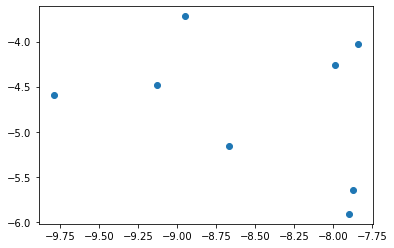

In [104]:
plt.scatter(experArr[0],calcArr[0])